## Useful Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Dataset file

In [4]:
imdb_dataset = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

## Explore Data

In [5]:
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
imdb_dataset.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [7]:
imdb_dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Visualize the distribution of sentiment labels (Positive and Negative)

<AxesSubplot:title={'center':'Distribution of Sentiment Labels'}, xlabel='sentiment', ylabel='count'>

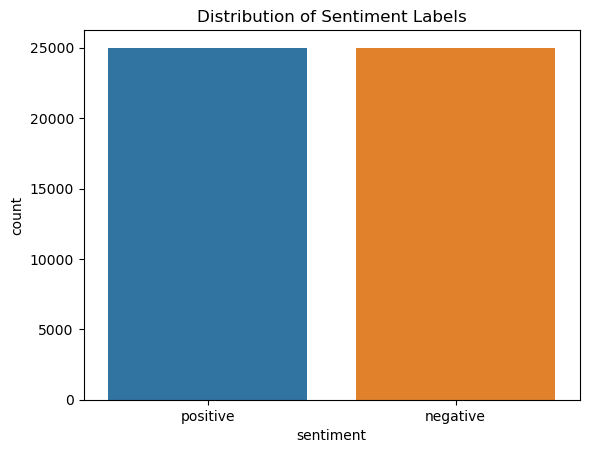

In [9]:
plt.title('Distribution of Sentiment Labels')
sns.countplot(data=imdb_dataset, x='sentiment')

We see that the number of instances in the the two sentiment labels (Positive and Negative) are roughly the same, so this means that it is a balanced dataset and there is no class imbalance problem here, and we can use **Accuracy** as the performance metric

In [10]:
X = imdb_dataset.drop(columns=['sentiment'])
y = imdb_dataset[['sentiment']]

## Cleaning and Encoding the IMDB Reviews

We will clean now the IMDB Reviews by performing the following cleaning steps:
1. Remove HTML tags and special characters
2. Remove punctuation and lowercase text
3. Remove stop words
4. Lemmatization

We will encode the sentiment labels and convert them to **one hot encoding**

In [11]:
def clean_imdb(text):
    """
    Cleans a string of text by performing the following steps:
    1. Removes HTML tags from the text using BeautifulSoup.
    2. Removes non-alphanumeric characters (including punctuation) from the text using regular expressions and
    converts the text to lowercase.
    3. Tokenizes the text into a list of words using the `nltk.word_tokenize()` function.
    4. Removes stop words from the list of words using the `nltk.corpus.stopwords()` module.
    5. Lemmatizes the list of words using the `nltk.stem.WordNetLemmatizer()` class.
    6. Joins the lemmatized list of words back into a single string.

    Args:
        text (str): A string of text to be cleaned.

    Returns:
        str: A cleaned version of the input text.
    """
    # Remove HTML tags and special characters
    text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML tags
    text = text.lower() # convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)  # remove non-alphanumeric characters

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Initialize the Porter Stemmer
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join the tokens back into a single string
    cleaned_text = " ".join(tokens)

    return cleaned_text

In [12]:
# clean the imdb reviews data
X_cleaned = X['review'].apply(clean_imdb)
X_cleaned = pd.DataFrame(X_cleaned,columns=['review'])
# encode the sentiment labels
y_encoded = pd.get_dummies(y, columns=['sentiment'])

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


## Divide the data into Train and Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_encoded, test_size=0.1, random_state=42)
print('The shape of X_train is', X_train.shape, 'and the shape of y_train is', y_train.shape)
print('The shape of X_test is', X_test.shape, 'and the shape of y_test is', y_test.shape)

The shape of X_train is (45000, 1) and the shape of y_train is (45000, 2)
The shape of X_test is (5000, 1) and the shape of y_test is (5000, 2)


## Tokenization and Vectorization of IMDB Reviews

We will Split the text into individual words or tokens.and then Convert the text data into numerical vectors that can be fed into a deep learning model

In [14]:
MAX_LEN = 250 # max length of padded sequences
VOCAB_SIZE = 80000

In [15]:
vectorizer_layer = TextVectorization(
        max_tokens= VOCAB_SIZE,
        output_sequence_length= MAX_LEN,
    )
vectorizer_layer.adapt(X_train['review'])

## Deep Learnig  Model Architecture

In [20]:
# hyperparameters
LOSS = 'binary_crossentropy'
OPTIMIZER = 'adam'
METRICS = ['accuracy']
ACTIVATION_OUTPUT = 'softmax'
ACTIVATION_LAYER = 'relu'
LSTM_UNITS = 64
FILTERS = 16
POOL_SIZE = 2
KERNEL_SIZE = 3
OUTPUT_DIM = 128
BATCH_SIZE = 128
EPOCHS = 5

In [21]:
def imdb_model(input_dim, output_dim, filters, kernel_size, pool_size, lstm_units, activation_layer, activation_output, max_len, loss, optimizer, metrics):
    model = Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorizer_layer,
        Embedding(input_dim= input_dim, output_dim= output_dim, input_length= max_len),
        Conv1D(filters= filters, kernel_size= kernel_size, activation= activation_layer),
        #Bidirectional(LSTM(units= lstm_units, return_sequences= True)),
        Bidirectional(LSTM(units= lstm_units)),
        Dense(units=32, activation = activation_layer),
        Dense(units=2, activation= activation_output)
    ])
    
    model.compile(loss= loss, optimizer= optimizer, metrics= metrics)
    return model

In [22]:
model = imdb_model(VOCAB_SIZE, OUTPUT_DIM, FILTERS, KERNEL_SIZE, POOL_SIZE, LSTM_UNITS, ACTIVATION_LAYER, ACTIVATION_OUTPUT, 
                   MAX_LEN, LOSS, OPTIMIZER, METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 250, 128)          10240000  
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 16)           6160      
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              41472     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 2)                

## Model Training

In [23]:
model.fit(X_train, y_train, batch_size= BATCH_SIZE, epochs= EPOCHS, validation_split= 0.1)

Epoch 1/5
317/317 [==============================] - 58s 169ms/step - loss: 0.3716 - accuracy: 0.8302 - val_loss: 0.2965 - val_accuracy: 0.8764
Epoch 2/5
317/317 [==============================] - 37s 116ms/step - loss: 0.1767 - accuracy: 0.9373 - val_loss: 0.3223 - val_accuracy: 0.8904
Epoch 3/5
317/317 [==============================] - 31s 99ms/step - loss: 0.0982 - accuracy: 0.9672 - val_loss: 0.3393 - val_accuracy: 0.8836
Epoch 4/5
317/317 [==============================] - 23s 74ms/step - loss: 0.0590 - accuracy: 0.9819 - val_loss: 0.4335 - val_accuracy: 0.8736
Epoch 5/5
317/317 [==============================] - 24s 75ms/step - loss: 0.0463 - accuracy: 0.9847 - val_loss: 0.4386 - val_accuracy: 0.8833


In [24]:
m , y = model.evaluate(X_test,y_test)
print(m, y)

157/157 [==============================] - 2s 12ms/step - loss: 0.4244 - accuracy: 0.8842
0.42438843846321106 0.8841999769210815
